# Project Proposal - Overview

Problem Statement:
This project aims to classify chest X-ray images into two categories: healthy ("No Finding") and diseased (any pathology present). Early detection of thoracic diseases is crucial for improving patient outcomes, and an automated system could assist radiologists by flagging abnormal images.

Dataset:
The NIH Chest X-ray dataset, sourced from Kaggle, contains over 100,000 chest X-ray images labeled with multiple disease findings. This dataset is widely used for research in medical imaging and machine learning.

Methodology:
A Convolutional Neural Network (CNN) will be used to classify images into healthy vs diseased. Images will be resized to 224×224 pixels for uniformity. The model will be implemented using PyTorch, a popular deep learning framework. Evaluation metrics will include accuracy, precision, recall, and F1-score.

# Preprocessing and Understanding

The NIH Chest X-ray dataset contains 112,000+ grayscale images labeled with one or more thoracic diseases.
The labels include 14 different disease categories (e.g., Pneumonia, Effusion, Infiltration), with many images having multiple conditions.

EDA revealed:

"No Finding" represents the majority of the images, creating a class imbalance.

The most common diseases after "No Finding" are Infiltration, Effusion, and Atelectasis.

Images are very large, mostly 1024×1024 pixels.

Random samples showed visible differences between healthy and diseased lungs.

In [73]:
# Libraries
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [74]:
# Reading the data
df = pd.read_csv('../data/Data_Entry_2017.csv')

In [75]:
# from eda file -- data folders for images
image_folders = [f'../data/images_{str(i).zfill(3)}' for i in range(1, 13)]

In [76]:
def find_image(image_name):
    """This function finds the image in the specified folders."""
    for folder in image_folders:
        full_path = f'{folder}/images/{image_name}'
        if os.path.exists(full_path):
            return full_path
    return None

In [77]:
# For filenames
available_images = set()
for folder in image_folders:
    folder_path = os.path.join(folder, 'images')
    for filename in os.listdir(folder_path):
        available_images.add(filename)

In [78]:
valid_df = df[df['Image Index'].isin(available_images)].reset_index(drop=True)

In [79]:
# Target variable -- finding vs no finding 
valid_df['target'] = valid_df['Finding Labels'].apply(lambda x: 0 if x == 'No Finding' else 1)

In [80]:
# Image transform with transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts to [0,1] and channel-first format
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale images to [-1, 1]
])

Image shape: (1024, 1024)
Image path: ../data/images_001/images/00000001_000.png
Transformed image shape: torch.Size([1, 224, 224])


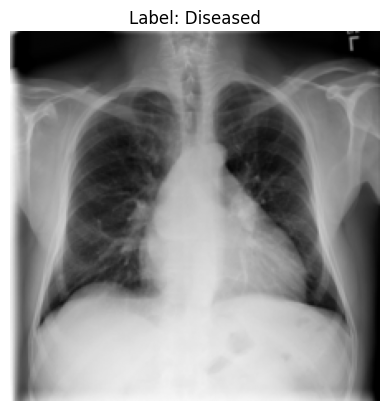

In [81]:
# Checking transform with sample image
ig = valid_df.iloc[0]
img_path = find_image(ig['Image Index'])
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
print(f'Image shape: {img.shape}')
print(f'Image path: {img_path}')
img_transformed = transform(img)
print("Transformed image shape:", img_transformed.shape)

# plotting
img_plot = img_transformed.clone()
img_plot = img_plot * 0.5 + 0.5  # Unnormalize [-1,1] -> [0,1]
img_plot = img_plot.squeeze(0).numpy()  # Remove channel dimension and convert to numpy

plt.imshow(img_plot, cmap='gray')
plt.title(f"Label: {'Healthy' if ig['target'] == 0 else 'Diseased'}")
plt.axis('off')
plt.show()

# Train/test datasets

The dataset came with a list of train and test images.

For good practice I am creating a class for datasets

In [82]:
# Libraries
from typing import Callable, Optional, Tuple
from sklearn.model_selection import train_test_split

In [83]:
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, transform: Optional[Callable] = None) -> None:
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with 'Image Index' and 'target' columns
            transform (Callable, optional): Transform to apply to images
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self) -> int:
        return len(self.dataframe)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        row = self.dataframe.iloc[idx]
        img_path = find_image(row['Image Index'])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            image = self.transform(image)

        label: int = int(row['target'])  # 0 = Healthy, 1 = Diseased

        return image, label

In [84]:
# Load train/val and test splits
with open('../data/train_val_list.txt', 'r') as f:
    train_val_files = set(line.strip() for line in f)

with open('../data/test_list.txt', 'r') as f:
    test_files = set(line.strip() for line in f)

# Make train/val and test DataFrames
train_val_df = valid_df[valid_df['Image Index'].isin(train_val_files)].reset_index(drop=True)
test_df = valid_df[valid_df['Image Index'].isin(test_files)].reset_index(drop=True)

In [85]:
# Further split for safety purposes
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    stratify=train_val_df['target'],
    random_state=42
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [86]:
val_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,target
0,00017394_003.png,No Finding,3,17394,51,M,AP,2500,2048,0.168000,0.168000,NaN,0
1,00001819_000.png,No Finding,0,1819,47,M,PA,2992,2991,0.143000,0.143000,NaN,0
2,00017256_001.png,No Finding,1,17256,56,F,PA,2402,2991,0.143000,0.143000,NaN,0
3,00011144_008.png,Effusion,8,11144,67,M,AP,2500,2048,0.168000,0.168000,NaN,1
4,00028812_000.png,Infiltration,0,28812,23,M,PA,2021,2021,0.194311,0.194311,NaN,1


# CNN Model Definition

Layer | Details

Conv2D | 16 filters, 3×3 kernel

ReLU | Activation

MaxPool2D | 2×2 pool

Conv2D | 32 filters, 3×3 kernel

ReLU | Activation

MaxPool2D | 2×2 pool

Fully Connected Layer | 128 units

Fully Connected Output | 1 unit (binary output: Healthy vs Diseased)

In [52]:
# Libraries
import torch.nn as nn
import torch.nn.functional as F

In [87]:
class ChestXrayCNN(nn.Module):
    def __init__(self) -> None:
        super(ChestXrayCNN, self).__init__()
        
        self.conv1: nn.Conv2d = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2: nn.Conv2d = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool: nn.MaxPool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1: nn.Linear = nn.Linear(32 * 56 * 56, 128)
        self.fc2: nn.Linear = nn.Linear(128, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(x.size(0), -1)             
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                      
        return x

## Key details:

Item | Value

Input shape | (batch_size, 1, 224, 224)

After conv1 + pool | (batch_size, 16, 112, 112)

After conv2 + pool | (batch_size, 32, 56, 56)

Flatten size | 32×56×56 = 100352 features

Final output | 1 logit per sample (Healthy or Diseased)

In [89]:
model: ChestXrayCNN = ChestXrayCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Sigmoid will be added in the loss function

Input (1×224×224)

↓

Conv2D (16 filters, 3×3) + ReLU

↓

MaxPool2D (2×2)

↓

Conv2D (32 filters, 3×3) + ReLU

↓

MaxPool2D (2×2)

↓

Flatten

↓

Dense (128 units) + ReLU

↓

Dense (1 unit) → Output logit


In [90]:
# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [92]:
from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_one_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [94]:
# Build datasets
train_dataset: ChestXrayDataset = ChestXrayDataset(train_df, transform=transform)
val_dataset: ChestXrayDataset = ChestXrayDataset(val_df, transform=transform)
test_dataset: ChestXrayDataset = ChestXrayDataset(test_df, transform=transform)

In [93]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)


In [ ]:
num_epochs = 5
best_val_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/5
Train Loss: 0.6680 | Train Acc: 0.6292
Val Loss:   0.6342 | Val Acc:   0.6461


Epoch 2/5
Train Loss: 0.6331 | Train Acc: 0.6454
Val Loss:   0.6305 | Val Acc:   0.6504


Epoch 3/5
Train Loss: 0.6267 | Train Acc: 0.6525
Val Loss:   0.6280 | Val Acc:   0.6499


Epoch 4/5
Train Loss: 0.6180 | Train Acc: 0.6587
Val Loss:   0.6266 | Val Acc:   0.6534


Epoch 5/5
Train Loss: 0.6060 | Train Acc: 0.6728
Val Loss:   0.6279 | Val Acc:   0.6522


# For post-crash or evaluation -- taking best model

In [95]:
model = ChestXrayCNN()
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval() 

ChestXrayCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [106]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Lists to store all labels and predictions
all_labels_1 = []
all_preds_1 = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        all_labels_1.extend(labels.cpu().numpy())
        all_preds_1.extend(preds.cpu().numpy())

In [107]:
# Flatten 
all_labels_1 = [label[0] for label in all_labels_1]
all_preds_1 = [pred[0] for pred in all_preds_1]

# Compute evaluation metrics
acc = accuracy_score(all_labels_1, all_preds_1)
prec = precision_score(all_labels_1, all_preds_1)
rec = recall_score(all_labels_1, all_preds_1)
f1 = f1_score(all_labels_1, all_preds_1)

# Print results
print("CNN Results")
print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall:    {rec:.4f}")
print(f"Test F1 Score:  {f1:.4f}")

CNN Results
Test Accuracy:  0.6364
Test Precision: 0.7048
Test Recall:    0.7030
Test F1 Score:  0.7039


# ResNet comparison

In [15]:
from torchvision import models

In [16]:
# Updated transform for ResNet (expects 3 channels)
transform_resnet = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # <- this is the important line!
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [19]:
resnet_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Modify the final fully connected layer for binary classification
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 1)

# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_model = resnet_model.to(device)

In [98]:
# Use the new transform
train_dataset_resnet = ChestXrayDataset(train_df, transform=transform_resnet)
val_dataset_resnet = ChestXrayDataset(val_df, transform=transform_resnet)
test_dataset_resnet = ChestXrayDataset(test_df, transform=transform_resnet)

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=128, shuffle=True, num_workers=0)
val_loader_resnet = DataLoader(val_dataset_resnet, batch_size=128, shuffle=False, num_workers=0)
test_loader_resnet = DataLoader(test_dataset_resnet, batch_size=128, shuffle=False, num_workers=0)

In [99]:
# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer (Adam)
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001)

In [25]:
num_epochs = 3
best_val_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(resnet_model, train_loader_resnet, optimizer, criterion, device)
    val_loss, val_acc = validate_one_epoch(resnet_model, val_loader_resnet, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    # Save best ResNet model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet_model.state_dict(), 'best_resnet_model.pth')

Epoch 1/3
Train Loss: 0.6048 | Train Acc: 0.6811
Val Loss:   0.5938 | Val Acc:   0.6916


Epoch 2/3
Train Loss: 0.5849 | Train Acc: 0.6980
Val Loss:   0.5878 | Val Acc:   0.7006


Epoch 3/3
Train Loss: 0.5769 | Train Acc: 0.7053
Val Loss:   0.5839 | Val Acc:   0.6976


In [26]:
resnet_model.load_state_dict(torch.load('best_resnet_model.pth'))
resnet_model = resnet_model.to(device)
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [100]:
# Evaluate
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader_resnet:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = resnet_model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

In [102]:
# Metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# Print results
print("ResNet Test Evaluation ")
print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall:    {rec:.4f}")
print(f"Test F1 Score:  {f1:.4f}")

ResNet Test Evaluation 
Test Accuracy:  0.6922
Test Precision: 0.7290
Test Recall:    0.7948
Test F1 Score:  0.7605


# Visualizations - Resnet18

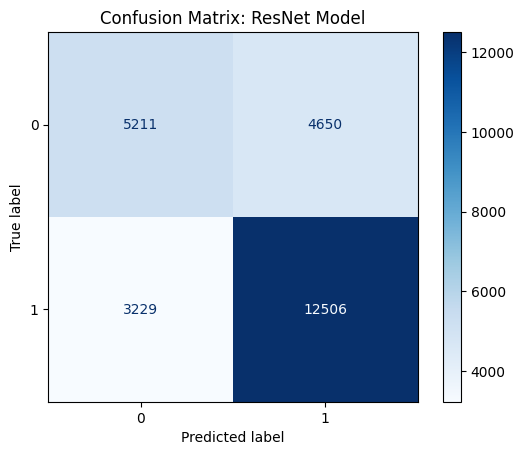

In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: ResNet Model')
plt.show()

# Visualizations - My CNN

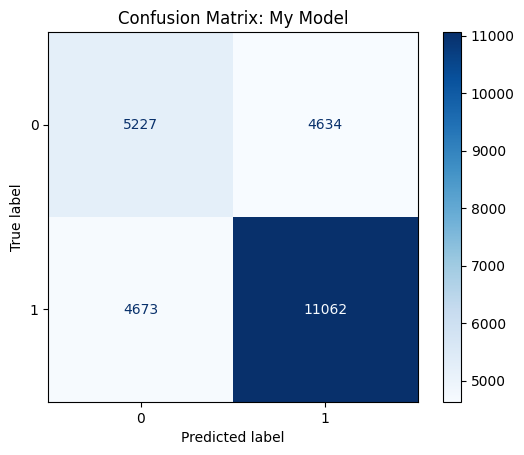

In [108]:
cm = confusion_matrix(all_labels_1, all_preds_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: My Model')
plt.show()